# Twitter Disaster Tweets Classification

This notebook performs a Kaggle Competition Exercise where we take a series of tweets provided by Kaggle and classify them as either referring to a disaster or not.   The competition and datas can be found at https://www.kaggle.com/c/nlp-getting-started/overview

The assignment exercises our ability to perform basic NLP techniques and use a Recurrent Neural Network to perform a binary classification on the tweets.

1.  Load packages   

Initial expected packages loaded

Additional Packages will be loaded as needed

In [ ]:
# import packagess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from google.colab import drive
import os
!pip install nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


#2. Data Description

Following cells load the data and run some basic function to view and understand the data.

The Data includes 7613 observations with the following features
ID
Keyword
location
 test
 target  (label)

 The location and keyword features have 2533 and 61 null values.  We will drop location  and I looked at keywords and since these are in the text as well will not use that feature.  The NLP model will use the text as the dependant variable and target as the label.  THere are no null text values.

 The printed out a sample of the text and can see that there are many characters that will have to be stripped along with application of stopword removal.

Mount Google Drive and Load the Data:

In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Disaster Tweet detection")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


Mounted at /content/drive


Basic Data Exploration:



In [ ]:
train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train.sample(10)

,id,keyword,location,text,target
3907,5557,flattened,NaN,100 1' MIX NEW FLAT DOUBLE SIDED LINERLESS BO...,0
6377,9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6822,9771,trapped,NaN,Hollywood movie about trapped miners released ...,0
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
4711,6699,lava,"Pocatello, Idaho",Perfect night for a soak! Lava here I come?? h...,0
4076,5794,hail,"Hattiesburg, MS",Two great 'dawgs' Dak and Jak !!! HAIL STATE ...,0
2854,4101,drought,Chappaqua NY and Redlands CA,U.S. record hurricane drought. http://t.co/fE9...,1
1812,2604,crashed,Pakistan,Maj Muzzamil Pilot Offr of MI-17 crashed near ...,1
5242,7496,oil%20spill,"Montgomery, AL",SB57 [NEW] Deepwater Horizon Oil Spill distrib...,1
1848,2658,crush,NaN,This guy idk just made me his woman crush ?? f...,0


In [ ]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
train.isnull().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
train['keyword'].value_counts()


fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

#3. Exploratory Data Analysis (EDA)

Exploring Data and performing some visualizations.

Checking for balance in the target class:



In [ ]:
print(train['target'].value_counts())


0    4342
1    3271
Name: target, dtype: int64


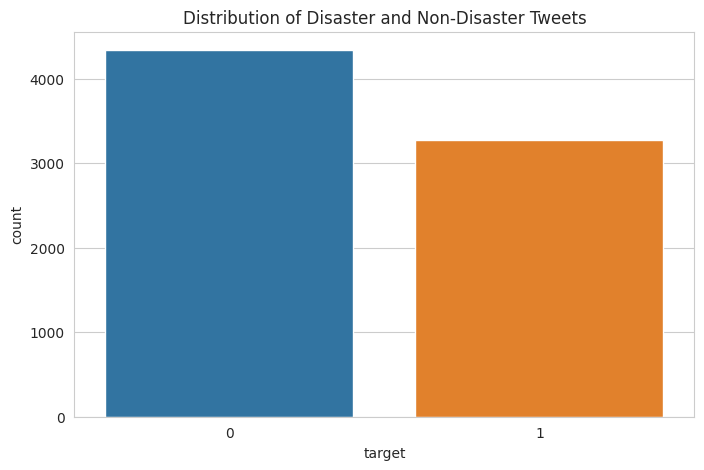

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=train)
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.show()


Label Balance evalutaion:  

Target is the label and the visualization above shows slight imbalance but this will not require treatment like under or over sampling.

3.  Data Ckeansing

Removing URLs, HTML tags, special characters, and numerical values:
Manual observation of the text feature shows many characters and stopwords.  

Below I created a method to remove URLs, HTML tags, special characters, and numerical values

I also am removing stopwords and later on i did some visualizastions and saw some words or alpha characters in high volume and added some custom words to the stop word treatment.

I also performed lemmatization to get rid of suffixes

Removing URLs, HTML tags, special characters, and numerical values:



In [ ]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove numbers
    text = re.sub(r'\d', ' ', text)
    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)


Removing Stopwords

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Add your custom stopwords
custom_stopwords = ['û_', 'via', 'u', 'amp']
stop_words.update(custom_stopwords)

train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Lemmatization

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

train['text'] = train['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
test['text'] = test['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


Showing cleansed text

In [ ]:
train.sample(10)

,id,keyword,location,text,target
1711,2467,collided,"Eau Claire, Wisconsin",eau claire man police said drunk suv collided ...,1
4732,6729,lava,"Clayton, NC",check lava lamp dude,1
3518,5029,eyewitness,Somewhere in Jersey,liked youtube video mini pony pack punch live ...,0
7213,10332,weapon,Denver Colorado. Fun Times,lol look tough people talk live gang infested ...,1
1725,2488,collided,"Peterborough, Ont.",newswatch vehicle collided lock lansdowne sts ...,1
4060,5769,forest%20fires,NaN,heartdisease u forest service say spending hal...,1
3430,4905,explode,NaN,anonchimp think tie thunderstorm tho make soul...,0
6105,8717,sinking,"Michigan, USA",û û lost amp alone sinking like stone carry onå å,0
1836,2641,crashed,NaN,already phone updated somehow phone crashed re...,0
3073,4408,electrocute,"Durand, MI",achievement unlocked replaced light socket ele...,0


## Additional Visualizations:

In addition to the histogram of target balance I am performing some visualizations to view top words in the disaster and non-disaster tweets


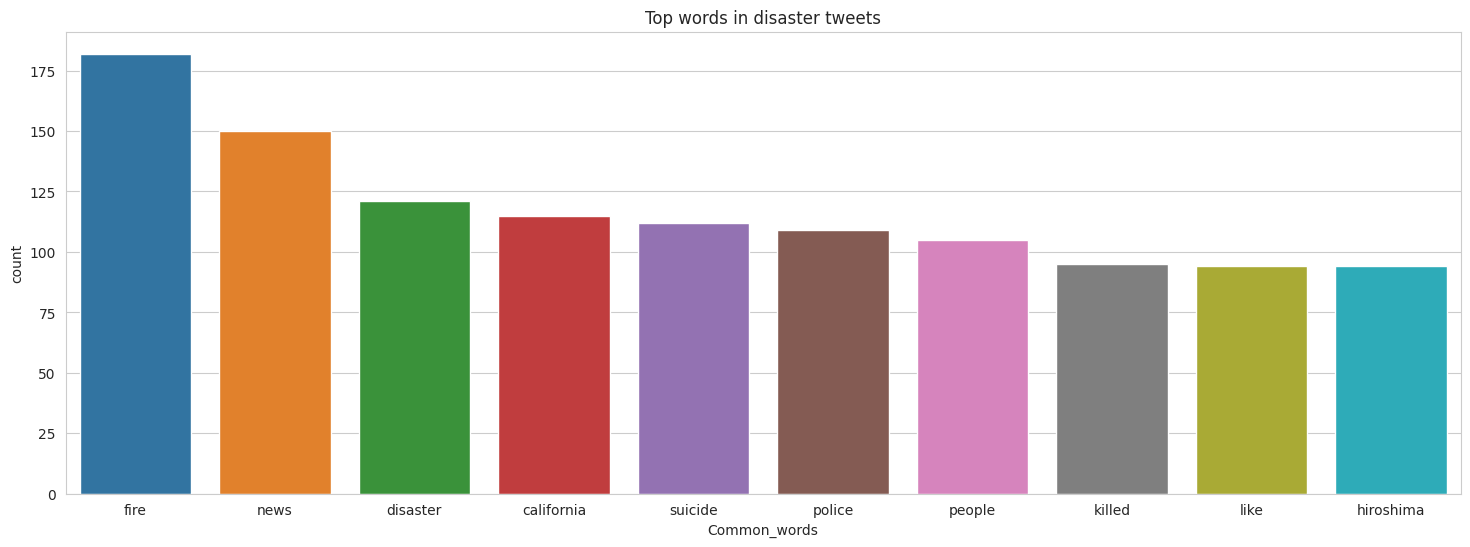

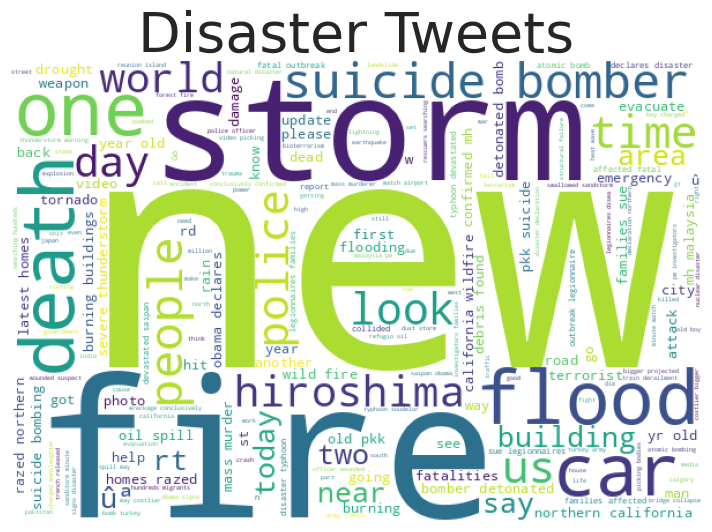

In [ ]:
# top words in disaster tweets
from collections import Counter
top = Counter([item for sublist in train[train['target'] == 1]['text'].str.split() for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']
plt.figure(figsize=(18,6))
sns.barplot(x='Common_words', y='count', data=temp)
plt.title('Top words in disaster tweets')
plt.show()

# word cloud
from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=[10,6])
wordcloud = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(train[train['target'] == 1]['text']))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title('Disaster Tweets',fontsize=40);

In [ ]:
print (temp)

  Common_words  count
0         fire    182
1         news    150
2     disaster    121
3   california    115
4      suicide    112
5       police    109
6       people    105
7       killed     95
8         like     94
9    hiroshima     94


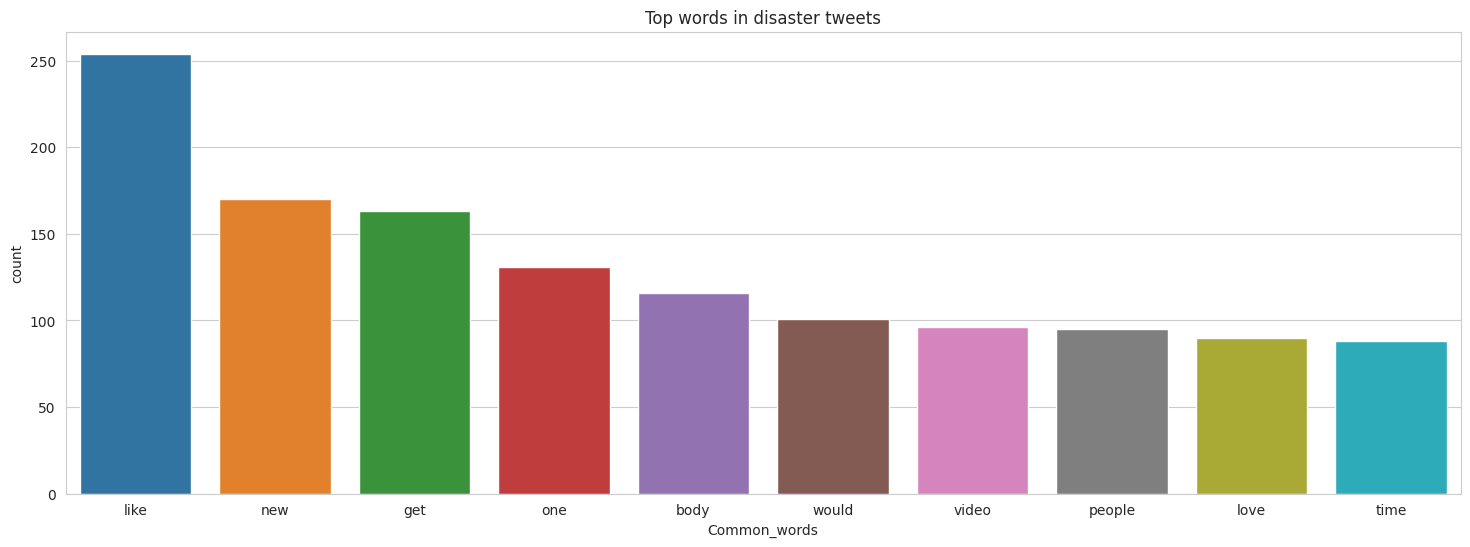

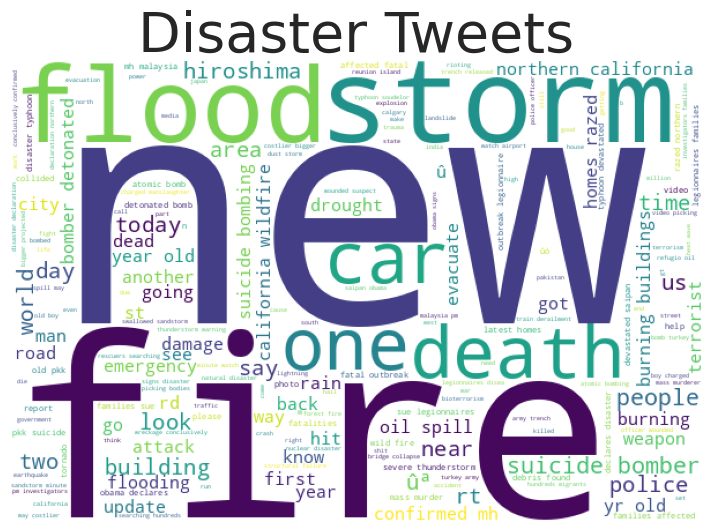

In [ ]:
# top words in non-disaster tweets
from collections import Counter
top = Counter([item for sublist in train[train['target'] == 0]['text'].str.split() for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']
plt.figure(figsize=(18,6))
sns.barplot(x='Common_words', y='count', data=temp)
plt.title('Top words in disaster tweets')
plt.show()

# word cloud
from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=[10,6])
wordcloud = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(train[train['target'] == 1]['text']))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title('Disaster Tweets',fontsize=40);

In [ ]:
# tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])

train_sequences = tokenizer.texts_to_sequences(train['text'])
test_sequences = tokenizer.texts_to_sequences(test['text'])

train_padded = pad_sequences(train_sequences)
test_padded = pad_sequences(test_sequences, maxlen=X_train_padded.shape[1])

# 4.  Model Training  
I am going to create three models.  

My first model will be simple.  It includes:

Embedded Layer to map each tolen/word to a sixed length vector

Spatial Dropout and Dropout Layers to assist in regualirization and mitigate overfitting   Spatial Dropout is specifically used for sequential data

Bidirectional LSTM  an RNN layer that processes both start to end and then end to start.

A Dense Layer with a signoid function for binary classification





In [ ]:
from sklearn.model_selection import train_test_split

# splitting the data into training and validation sets
X_train_padded, X_val_padded, y_train, y_val = train_test_split(train_padded, train['target'].values, test_size=0.2, random_state=42)


In [ ]:
from keras.metrics import Precision, Recall

# define the F1 score
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout1D, Bidirectional
from keras import backend as K


# model parameters
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100
MAX_LENGTH = X_train_padded.shape[1]  # Adjust based on the processed data
# Adjusting the model

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compiling with F1 metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

# adjusting the EarlyStopping monitor to F1
early_stop = EarlyStopping(monitor='val_f1', mode='max', patience=2, restore_best_weights=True)

# training the model
history = model.fit(X_train_padded, y_train,
                    validation_data=(X_val_padded, y_val),
                    epochs=5,
                    batch_size=32,
                    callbacks=[early_stop])

Epoch 1/5
191/191 [==============================] - 42s 189ms/step - loss: 0.5876 - accuracy: 0.6806 - f1: 0.3991 - val_loss: 0.4628 - val_accuracy: 0.7807 - val_f1: 0.7261
Epoch 2/5
191/191 [==============================] - 28s 149ms/step - loss: 0.3343 - accuracy: 0.8663 - f1: 0.8296 - val_loss: 0.4800 - val_accuracy: 0.7814 - val_f1: 0.7302
Epoch 3/5
191/191 [==============================] - 28s 145ms/step - loss: 0.1970 - accuracy: 0.9279 - f1: 0.9117 - val_loss: 0.5740 - val_accuracy: 0.7649 - val_f1: 0.7213
Epoch 4/5
191/191 [==============================] - 29s 149ms/step - loss: 0.1217 - accuracy: 0.9593 - f1: 0.9512 - val_loss: 0.6694 - val_accuracy: 0.7597 - val_f1: 0.7150


In [ ]:
# method to create metric charts
def plot_training_history(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    ax2.plot(history.history['f1'])
    ax2.plot(history.history['val_f1'])
    ax2.set_title('Model F1 score')
    ax2.set(xlabel='Epoch', ylabel='F1 Score')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    fig.suptitle(title)
    plt.show()


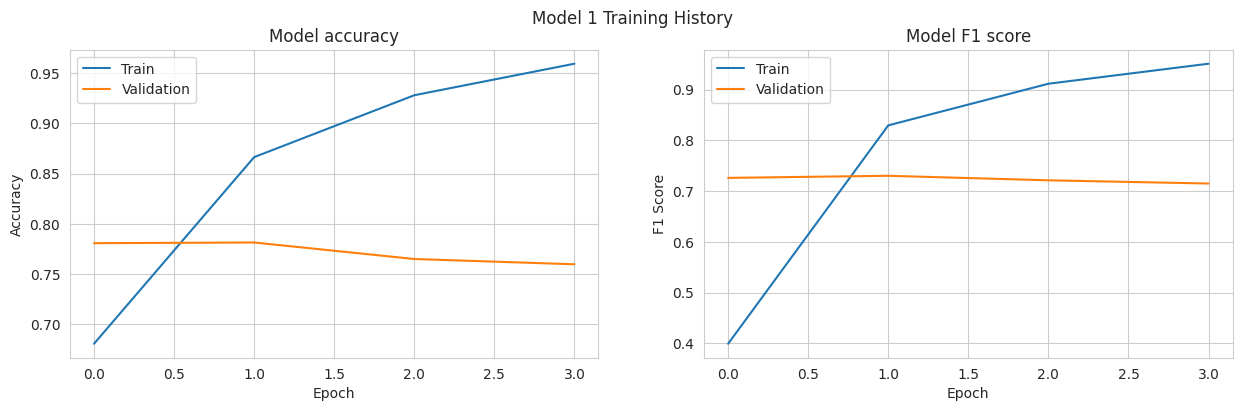

In [ ]:
plot_training_history(history, "Model 1 Training History")


## Model 1 Analysis  

ALthough the training metrics consistently improve yo an F1 of 0.9512, the validation score starts falling after epoch 2 eventually causing early stopping with an F1 at epoch 2 of 0.7302   This indicates overfitting and my tuning will try to fix this.

## Model 2  Tuning the model
I am going to make several changes to address the overfitting

Increasing the dropout by increasing the hyperparameters in both dropout layers by 0.1 which should increase regularization

Adding an additional Bidirectional LSTM layer to increase the comnplexity the model can learn

Increasing the dropout hyperparameters within the LSTM layers also to increase regularization

Use a decaying learning rate to try to improve convergence

reducing the batch size which also should add regularization




In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# model parameters
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100
MAX_LENGTH = X_train_padded.shape[1]

model_2 = Sequential()
model_2.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH))
model_2.add(SpatialDropout1D(0.4))
model_2.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)))
model_2.add(Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5)))
model_2.add(Dropout(0.6))
model_2.add(Dense(1, activation='sigmoid'))

# ssing a decaying learning rate
optimizer = Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

# implementing early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_f1', mode='max', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

# training the model with a smaller batch size and adding callbacks
history_2 = model_2.fit(X_train_padded, y_train,
                    validation_data=(X_val_padded, y_val),
                    epochs=5,
                    batch_size=16,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/5
381/381 [==============================] - 125s 297ms/step - loss: 0.5642 - accuracy: 0.6990 - f1: 0.4917 - val_loss: 0.4559 - val_accuracy: 0.7938 - val_f1: 0.7060 - lr: 0.0010
Epoch 2/5
381/381 [==============================] - 105s 275ms/step - loss: 0.3406 - accuracy: 0.8667 - f1: 0.8251 - val_loss: 0.4602 - val_accuracy: 0.7991 - val_f1: 0.7461 - lr: 0.0010
Epoch 3/5
381/381 [==============================] - 104s 274ms/step - loss: 0.1901 - accuracy: 0.9346 - f1: 0.9169 - val_loss: 0.5466 - val_accuracy: 0.7912 - val_f1: 0.7412 - lr: 2.0000e-04
Epoch 4/5
381/381 [==============================] - 103s 270ms/step - loss: 0.1593 - accuracy: 0.9447 - f1: 0.9305 - val_loss: 0.6097 - val_accuracy: 0.7840 - val_f1: 0.7373 - lr: 1.0000e-04


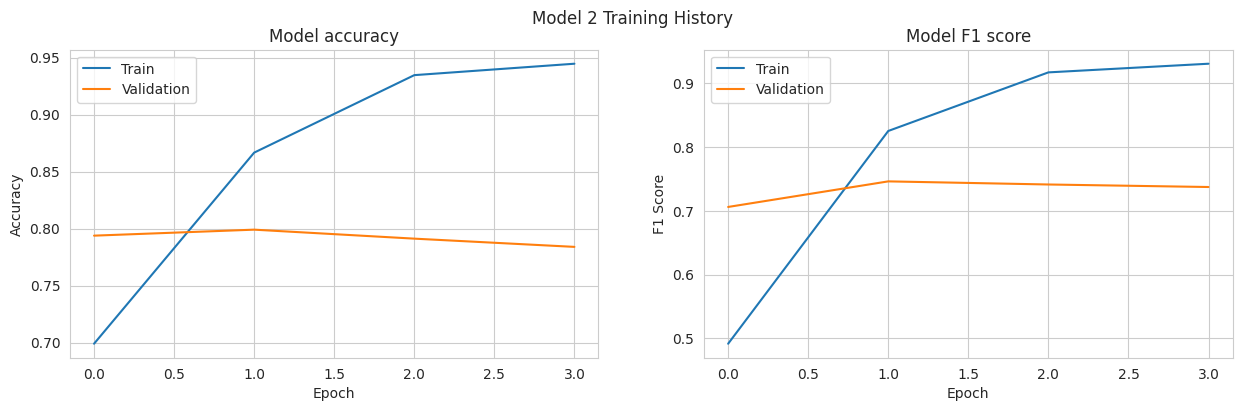

In [ ]:
plot_training_history(history_2, "Model 2 Training History")

## Model 2 Analysis  

This model still showed overfitting but not as much as the first model.  The Training metrics were still very good and the validation F1 max  improved to 0.7461 SO the decaying learning rate and the regularization additions appear to have imnrpoved the model but not as much as i would like.

## Model 3  Further tuning the model
I am going to make further changes to address the overfitting

Increasing the dropout again  by increasing the hyperparameters in both dropout layers by 0.1 which should increase regularization

Adding L2 regularization hyperparameters to the LTSM RNN layer to increate regularization

I am also reducing the LTSM units to 50 from 64 hopinbg a less complex model will help with less overfitting

I am hoping these futher regularization addtionls to the model reduce overfitting

In [ ]:
from keras.regularizers import l2

# model parameters
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100
MAX_LENGTH = X_train_padded.shape[1]

model_3 = Sequential()
model_3.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH))
model_3.add(SpatialDropout1D(0.5))  # Increased dropout
model_3.add(Bidirectional(LSTM(50, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001))))  # Regularization & fewer LSTM units
model_3.add(Dropout(0.6))
model_3.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

early_stop = EarlyStopping(monitor='val_f1', mode='max', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

# training the model with a smaller batch size and the callbacks
history_3 = model_3.fit(X_train_padded, y_train,
                    validation_data=(X_val_padded, y_val),
                    epochs=5,
                    batch_size=16,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/5
381/381 [==============================] - 69s 165ms/step - loss: 0.6848 - accuracy: 0.6634 - f1: 0.3614 - val_loss: 0.5095 - val_accuracy: 0.7866 - val_f1: 0.6917 - lr: 0.0010
Epoch 2/5
381/381 [==============================] - 54s 140ms/step - loss: 0.4159 - accuracy: 0.8412 - f1: 0.7872 - val_loss: 0.4928 - val_accuracy: 0.7846 - val_f1: 0.7315 - lr: 0.0010
Epoch 3/5
381/381 [==============================] - 53s 139ms/step - loss: 0.3087 - accuracy: 0.8918 - f1: 0.8560 - val_loss: 0.5091 - val_accuracy: 0.7833 - val_f1: 0.7301 - lr: 0.0010
Epoch 4/5
381/381 [==============================] - 53s 140ms/step - loss: 0.2235 - accuracy: 0.9300 - f1: 0.9090 - val_loss: 0.5473 - val_accuracy: 0.7899 - val_f1: 0.7385 - lr: 2.0000e-04
Epoch 5/5
381/381 [==============================] - 53s 139ms/step - loss: 0.2099 - accuracy: 0.9361 - f1: 0.9177 - val_loss: 0.5566 - val_accuracy: 0.7899 - val_f1: 0.7377 - lr: 1.0000e-04


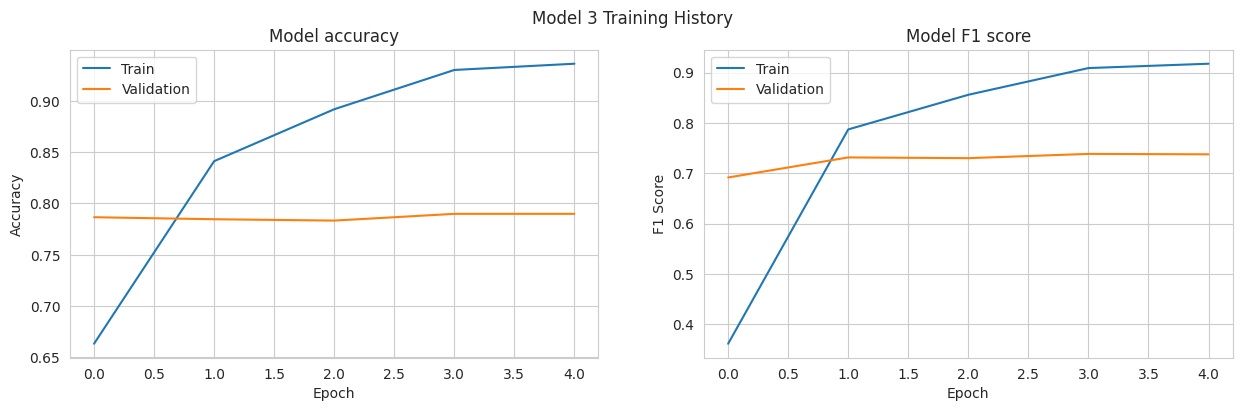

In [ ]:
plot_training_history(history_3, "Model 3 Training History")

## Model 2 Analysis  

This model had less overfitting than the previous 3 with smaller gaps between the training and validation scores and the validation F1 did not decrease until after epoch 4 but the highest scores were lower than the previous model 2 so perhaps the reduction of units in the LTSM model was a mistake resulting in lower metrics than model 2

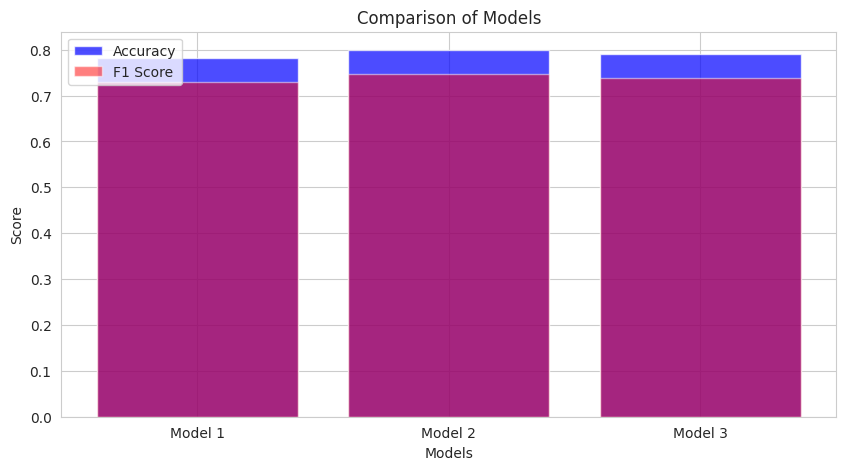

In [ ]:
#code to plot all three models
models = ['Model 1', 'Model 2', 'Model 3']
model_1_val_acc = max(history.history['val_accuracy'])
model_2_val_acc = max(history_2.history['val_accuracy'])
model_3_val_acc = max(history_3.history['val_accuracy'])

model_1_val_f1 = max(history.history['val_f1'])
model_2_val_f1 = max(history_2.history['val_f1'])
model_3_val_f1 = max(history_3.history['val_f1'])

accuracy = [model_1_val_acc, model_2_val_acc, model_3_val_acc]
f1_scores = [model_1_val_f1, model_2_val_f1, model_3_val_f1]

plt.figure(figsize=(10,5))
plt.bar(models, accuracy, color='blue', alpha=0.7, label='Accuracy')
plt.bar(models, f1_scores, color='red', alpha=0.5, label='F1 Score')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Models')
plt.legend(loc='upper left')
plt.show()


## Cross model analysis  

Model 2 had the nest validatioln scores  with an F1 of 0.7461  and a training F1 of 0.8251  for the same epoch  I was never able to effectively reduce the overfitting to my satisfaction.   Model 3 had the least overfitting but by simnplifying the RNN i achieved lower F1 scores,  By using callbacks and code to choose and save the best model  we will use that to predict against the test texts.

## Predict and Save Test Results

In [ ]:
best_model_index = np.argmax(f1_scores)
best_model = [model, model_2, model_3][best_model_index]


In [ ]:
predictions = best_model.predict(test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

submission = pd.DataFrame({
    'id': test['id'],
    'target': predictions
})

# save to a CSV file
submission.to_csv('disaster_submission.csv', index=False)

# download the file to your local system
from google.colab import files
files.download('disaster_submission.csv')


102/102 [==============================] - 3s 25ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5.  Conclusions

When I ran the final predictions and submitted to the Kaggle competion I got an F1 Score of o.798  a nuch better result than I had seen in my validation results.  So the model i produced did not suffer from the same level of overfitting and I was fairly satisifed with that result.   If I were to continue tuning the model I would have continued to try different techiniques liek data augmentation to get the validation results closer to my very good training results.  

I would also try some non-Deep Learning models to see how they fare against the deep learning techniques.  

Overall This assignment helped me try different RNN techinques and learn about the hyperparameters and how they help me alter the overfitting and complexity challenges for an RNN in NLP.  They also helped me practice basic NLP data cleansing methods.